In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install scikit-learn scikit-image

In [2]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage.filters import gabor_kernel, gabor
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

np.random.seed(42)

In [3]:
# Define the path to save the dataset
dataset_path = 'mnist_784.pkl'

# Check if the dataset is already saved to the local file
if os.path.exists(dataset_path):
    print('Loading the dataset from the local file...')
    ds = joblib.load(dataset_path)
else:
    print('Downloading the dataset from OpenML...')
    ds = fetch_openml('mnist_784', as_frame=False)
    print('Saving the dataset to the local file...')
    joblib.dump(ds, dataset_path)

Loading the dataset from the local file...


In [4]:
# Convert the data to a DataFrame
data = pd.DataFrame(ds.data)
labels = pd.Series(ds.target.astype(int))

# Stores the final dataset (1000 for each digit)
final_data = pd.DataFrame()
final_labels = pd.Series(dtype=int)

# Loop through each digit (0-9)
for digit in range(10):
    digit_samples = data[labels == digit]
    sampled_digit = digit_samples.sample(n=1000, random_state=42)
    final_data = pd.concat([final_data, sampled_digit])
    final_labels = pd.concat([final_labels, pd.Series([digit] * 1000, dtype=int)])

# Convert to arrays
final_data = final_data.values
final_labels = final_labels.values

# Normalize the data (very important)
final_data = final_data / 255.0

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(final_data, final_labels, test_size=0.2, random_state=42)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (8000, 784)
y_train shape: (8000,)
x_test shape: (2000, 784)
y_test shape: (2000,)


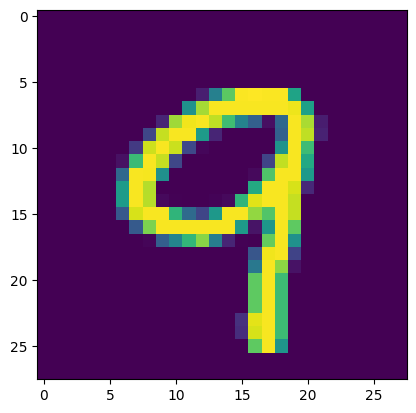

In [5]:
# Display a image (28, 28)
a = x_train[0].reshape((28,28))
plt.imshow(a)

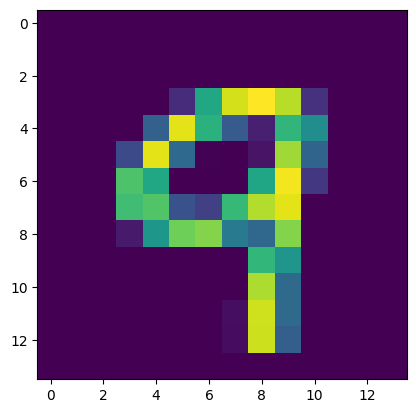

In [6]:
# Resize to (14, 14)
a_resize = cv2.resize(a, (14,14))
plt.imshow(a_resize)

x_train_resize = np.zeros((x_train.shape[0], 196))
for i in range(x_train.shape[0]):
  x_train_resize[i] = cv2.resize(x_train[i].reshape((28,28)), (14,14)).reshape(196)

x_test_resize = np.zeros((x_test.shape[0], 196))
for i in range(x_test.shape[0]):
  x_test_resize[i] = cv2.resize(x_test[i].reshape((28,28)), (14,14)).reshape(196)

In [7]:
# Define and fit the classifier
classifier = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
classifier.fit(x_train_resize, y_train)

SVC(gamma='auto')

In [8]:
# Use the classifier to predict the test data
y_pred = classifier.predict(x_test_resize)

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)

Accuracy: 0.911
Error rate: 0.08899999999999997


In [10]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       208
           1       0.92      0.98      0.95       202
           2       0.89      0.91      0.90       192
           3       0.94      0.83      0.88       201
           4       0.95      0.90      0.92       209
           5       0.85      0.90      0.88       186
           6       0.94      0.95      0.94       211
           7       0.91      0.91      0.91       204
           8       0.92      0.89      0.90       212
           9       0.84      0.90      0.87       175

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [11]:
conf_matrix_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix_result)

Confusion Matrix:
 [[198   0   1   0   1   1   2   1   4   0]
 [  0 197   1   2   0   0   0   1   1   0]
 [  5   0 174   1   1   0   2   5   4   0]
 [  1   2  10 166   1   9   0   3   7   2]
 [  0   0   2   0 188   0   3   1   1  14]
 [  2   3   3   2   2 168   4   0   0   2]
 [  3   1   1   0   3   3 200   0   0   0]
 [  0   2   1   0   1   4   0 185   0  11]
 [  0   6   1   1   0  11   2   1 188   2]
 [  0   2   2   4   1   1   0   7   0 158]]


In [12]:
# Search for a better hyperparameter C
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 500, 1000]  # Values of C to try
}

# Create the GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-2)

# Fit the model
grid_search.fit(x_train_resize, y_train)

# Show all the results in a table
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')
print(results[['param_C', 'mean_test_score', 'rank_test_score']])

# Print the best hyperparameters
print("Best hyper-parameters:", grid_search.best_params_)

  param_C  mean_test_score  rank_test_score
2     100         0.938125                1
3     500         0.937000                2
4    1000         0.935750                3
1      10         0.929250                4
0       1         0.908125                5
Best hyper-parameters: {'C': 100}


In [13]:
# Use the best classifier to predict the test data
y_pred = grid_search.best_estimator_.predict(x_test_resize)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)


Accuracy: 0.9435
Error rate: 0.056499999999999995


In [14]:
# Create a smaller dataset for the next task
# Training dataset - 100 samples, validation dataset - 100 samples, no test dataset
# Previous training dataset has 8000 samples, validation dataset has 2000 samples
# Randomly select 100 samples from the training dataset and 100 samples from the validation dataset

num_train_samples = 100
num_val_samples = 100

# Training dataset
x_train_small = np.zeros((num_train_samples, 196))
y_train_small = np.zeros(num_train_samples)
for i in range(num_train_samples):
    idx = np.random.randint(0, 8000)
    x_train_small[i] = x_train_resize[idx]
    y_train_small[i] = y_train[idx]

# Validation dataset
x_val_small = np.zeros((num_val_samples, 196))
y_val_small = np.zeros(num_val_samples)
for i in range(num_val_samples):
    idx = np.random.randint(0, 2000)
    x_val_small[i] = x_test_resize[idx]
    y_val_small[i] = y_test[idx]

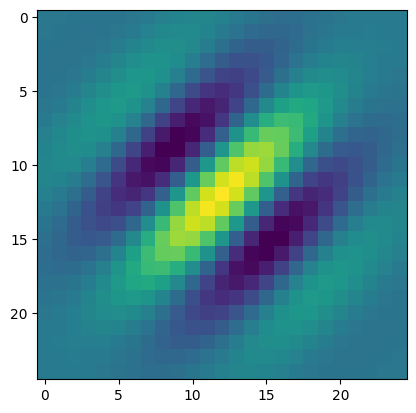

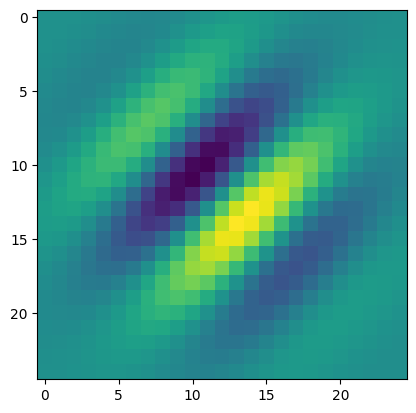

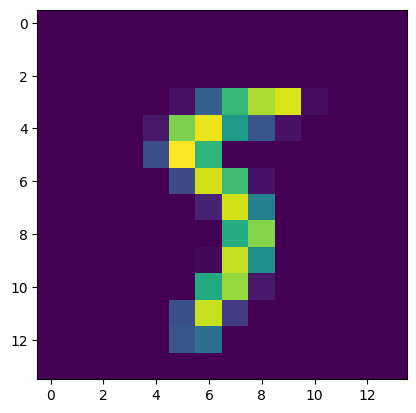

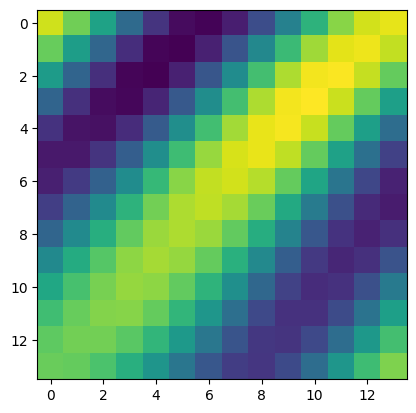

In [15]:
freq, theta, bandwidth = 0.1, np.pi / 4, 1
# freq, theta, bandwidth = 0.05, 0, 0.3
gk = gabor_kernel(frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(1); plt.clf(); plt.imshow(gk.real)
plt.figure(2); plt.clf(); plt.imshow(gk.imag)

# convolve the input image with the kernel and get co-efficients
# we will use only the real part and throw away the imaginary
# part of the co-efficients
image = x_train_small[0].reshape((14,14))
coeff_real, _ = gabor(image, frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(3); plt.clf(); plt.imshow(image)
plt.figure(4); plt.clf(); plt.imshow(coeff_real)

In [16]:
theta_arr = np.arange(0, np.pi, np.pi / 4)
frequency_arr = np.arange(0.05, 0.5, 0.15)
bandwidth_arr =  np.arange(0.3, 1, 0.3)

filter_bank = []

class GaborFilter:
    def __init__(self, fr, th, bdwidth, gkfilter):
        self.frequency = fr
        self.theta = th
        self.bandwidth = bdwidth
        self.gk = gkfilter

plot_figure = False
for t in theta_arr:
    if plot_figure:
        fig, axs = plt.subplots(len(frequency_arr), len(bandwidth_arr) * 2, figsize=(24, 8))
        fig.suptitle(fr'Gabor Filters: $\theta$={t/np.pi}$\pi$')
        plt.subplots_adjust(wspace=-0.5, hspace=0.2)  # Adjust the space between subplots
    
    for i, f in enumerate(frequency_arr):
        for j, b in enumerate(bandwidth_arr):
            gk = gabor_kernel(frequency=f, theta=t, bandwidth=b)
            filter_bank.append(GaborFilter(f, t, b, gk))
            # image = x_train_small[0].reshape((14, 14))
            # coeff_real, _ = gabor(image, frequency=f, theta=t, bandwidth=b)

            if plot_figure:
                axs[i, j * 2].imshow(gk.real)
                axs[i, j * 2].set_title(f'Real: Freq={f:.2f}, Band={b:.2f}')
                axs[i, j * 2].axis('off')

                axs[i, j * 2 + 1].imshow(gk.imag, cmap='jet')
                axs[i, j * 2 + 1].set_title(f'Imag: Freq={f:.2f}, Band={b:.2f}')
                axs[i, j * 2 + 1].axis('off')
    if plot_figure:
        plt.show(fig)
        plt.close(fig)

print(f"Total filters stored: {len(filter_bank)}")

Total filters stored: 36


: 

In [17]:
# Use the Gabor filters to extract features from the images
x_train_gabor = []
for i in tqdm(range(num_train_samples), desc="Processing x_train_small"):
    image = x_train_small[i].reshape((14, 14))
    features_real = []
    for gk in filter_bank:
        coeff_real, _ = gabor(image, frequency=gk.frequency, theta=gk.theta, bandwidth=gk.bandwidth)
        features_real.append(coeff_real)
    x_train_gabor.append(np.array(features_real).reshape(-1))
    assert len(x_train_gabor[i]) == 196 * len(filter_bank)  # 7056

x_val_gabor = []
for i in tqdm(range(num_val_samples), desc="Processing x_val_small"):
    image = x_val_small[i].reshape((14, 14))
    features_real = []
    for gk in filter_bank:
        coeff_real, _ = gabor(image, frequency=gk.frequency, theta=gk.theta, bandwidth=gk.bandwidth)
        features_real.append(coeff_real)
    x_val_gabor.append(np.array(features_real).reshape(-1))
    assert len(x_val_gabor[i]) == 196 * len(filter_bank)  # 7056

Processing x_val_small:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print(np.isnan(x_train_gabor).any())
print(np.isinf(x_train_gabor).any())
print(np.isnan(x_val_gabor).any())
print(np.isinf(x_val_gabor).any())

In [18]:
# # Normalize the data
# scaler = StandardScaler()
# x_train_gabor = scaler.fit_transform(x_train_gabor)
# x_val_gabor = scaler.transform(x_val_gabor)

In [19]:
# # Initialize PCA with the desired number of components
# n_components = 50  # You can adjust this number based on your needs
# pca = PCA(n_components=n_components)
#
# # Fit PCA on the training data and transform both training and test data
# x_train_gabor = pca.fit_transform(x_train_gabor)
# x_val_gabor = pca.transform(x_val_gabor)
#
# # Print the shape of the transformed data
# print("x train pca shape:", x_train_gabor.shape)
# print("x valid pca shape:", x_val_gabor.shape)

In [ ]:
# Define and fit the classifier
classifier_gk = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
classifier_gk.fit(x_train_gabor, y_train_small)

In [ ]:
# Use the classifier to predict the validation data
y_pred_gk = classifier_gk.predict(x_val_gabor)

In [ ]:
# Evaluate the model
accuracy_gk = accuracy_score(y_val_small, y_pred_gk)
print("Accuracy:", accuracy_gk)
print("Error rate:", 1 - accuracy_gk)


In [ ]:
# Search for better hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
grid_search_gk = GridSearchCV(classifier_gk, param_grid, cv=5, scoring='accuracy', n_jobs=-2)
grid_search_gk.fit(x_train_gabor, y_train_small)

# Show all the results in a table
results_gk = pd.DataFrame(grid_search_gk.cv_results_)
results_gk = results_gk.sort_values(by='rank_test_score')
print(results_gk[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'rank_test_score']])
print("Best hyper-parameters:", grid_search_gk.best_params_)

In [ ]:
# Use the best classifier to predict the validation data
y_pred_gk = grid_search_gk.best_estimator_.predict(x_val_gabor)
accuracy_gk = accuracy_score(y_val_small, y_pred_gk)
print("Accuracy:", accuracy_gk)
print("Error rate:", 1 - accuracy_gk)